Read CSV
Generate Table with headings
Generate y_train data
    Read Steering Angle
Generate X_train data
    Read images (center, left, right) using filename
    Crop
    Augment
        Flip,resize - append(y_train, offset)
        Noise, resize - append(y_train, offset)
        blur, resize - append(y_train, offset)

Neural Network Implmentation
training, validation, testing split
Generator Function

Neural Network Training
Save Model

    

### Read CSV

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
csv_headers = ["center", "left", "right", "steering", "throttle", "brake", "speed"]

data = pd.read_csv('CarSim_data/driving_log.csv', names=csv_headers)

In [3]:
# data.head()

### Read Image, Crop and Resize

In [4]:
for i in data['center']:
    print(i)

/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_355.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_421.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_491.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_559.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_625.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_693.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_761.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_829.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/center_2017_02_24_17_45_07_896.jpg
/home/anuj/research/sdc/CarND-Behavioral-Cloning-P3/CarSim_data/IMG/cente

### Features

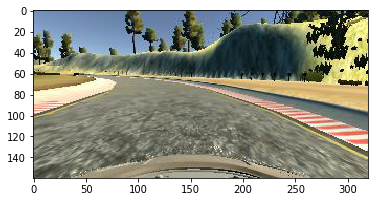

In [5]:
img_path = data['center'][1]
#print(img_path)
num_samples = len(data)
i=0
for row in data['center']:
#     print(i)
    I = cv2.imread(img_path)
    b,g,r = cv2.split(I)
    I = cv2.merge([r,g,b])
    #cv2.imwrite('I.jpg',I)
#     I = I[50:,:]
#     I = cv2.resize(I,None,fx=0.25,fy=0.25,interpolation=cv2.INTER_AREA)
    plt.imshow(I)
    
    # https://carnd-forums.udacity.com/questions/32716893/
    # does-anyone-know-how-to-make-multiple-images-into-4d-arrays-like-pickled-data#
    #arr = np.zeros((num_examples, width, height, channels))

    X_train = np.zeros((num_samples, I.shape[0], I.shape[1], I.shape[2]))
    X_train[i, :, :, :] = I
    i=i+1

In [6]:
print(type(I))
print(I.shape)

<class 'numpy.ndarray'>
(160, 320, 3)


### Labels

In [7]:
# Convert a pandas dataframe (df) to a numpy ndarray
y_train = data['steering'].values
print(y_train.shape)

(1566,)


### Create Features and Labels

### Preprocess the Data
1.) Shuffle the data

2.) Normalize the features using Min-Max scaling between -0.5 and 0.5

3.) Steering Angle: -25 to 25


### Generator

In [8]:
import sklearn
import pandas
from sklearn.utils import shuffle
import csv

In [9]:
samples = []
with open('./CarSim_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [10]:
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [11]:
print(len(train_samples))

1252


In [12]:
def myGenerator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # loop forever so generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
#                 name = './CarSim_data/IMG/'+batch_sample[0].split('/')[-1]
                name = batch_sample[0]
#                 print(name)
                center_image = cv2.imread(name)
                plt.imshow(center_image)
#                 print(center_image.shape)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            X_train = np.array(images)
            print(X_train.shape)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [13]:
# compile and train the model using generator function
train_generator = myGenerator(train_samples, batch_size=32)
validation_generator = myGenerator(validation_samples, batch_size=32)

In [14]:
type(train_generator)

generator

## Keras Model

In [15]:
from keras.models import Sequential
from keras.layers import Activation, Convolution2D, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.optimizers import Adam
#from keras.layers.normalization import BatchNormalization


Using TensorFlow backend.


In [22]:
from keras.utils.visualize_util import plot

ImportError: No module named 'pydot'

In [16]:
ch, row, col = 3,320,160

In [17]:
model = Sequential()

model.add(Lambda(lambda x: x/127.5-1., input_shape=(col, row, ch), output_shape=(col, row, ch)))


model.add(Convolution2D(24,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(36,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(48,5,5, init='glorot_uniform', subsample=(2, 2), border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(64,3,3, init='glorot_uniform', border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Convolution2D(64,3,3, init='glorot_uniform', border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(1, 1)))

model.add(Flatten())
model.add(Dropout(0.2))
model.add(Activation('relu'))

model.add(Dense(1164))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(100))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(50))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))

In [18]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 80, 160, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 79, 159, 24)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 40, 80, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

In [19]:
model.compile(loss='mse', optimizer='adam')

Epoch 1/4
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
 672/1252 [===============>..............] - ETA: 3s - loss: 0.2055(32, 160, 320, 3)
(32, 160, 320, 3)
1088/1252 [=========================>....] - ETA: 0s - loss: 0.1437(32, 160, 320, 3)
(32, 160, 320, 3)
1248/1252 [============================>.] - ETA: 0s - loss: 0.1318(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(32, 160, 320, 3)
(26, 160, 320, 3)
(32, 160, 320, 3)
1252/1252 [==============================] - 7s - loss: 0.1314 - val_loss: 0.0417
Epoch 2/4
(32, 160, 320, 3)
 608/1252 [=============>................] - ETA: 2s - loss: 0.0447

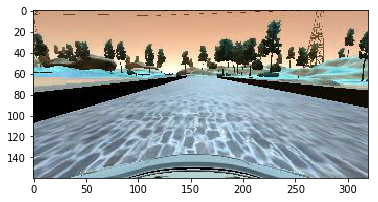

In [20]:
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=4)

### Save Model

In [21]:
import json

model_json = model.to_json()
with open ('model.json', 'w') as f:
    json.dump(model_json, f, indent=4, sort_keys=True, separators=(',', ':'))
    
# model.save_weights will only save the weights
model.save('model.h5')
print("Model Saved")

Model Saved
